In [3]:
from PIL import Image
import os.path
import numpy as np
import itertools
import keras.backend as K
import keras
from IPython.display import clear_output
import pandas
import time
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def resizeImg(action, x , y):
    avgX = x
    avgY = y
    counter = 0
    filelist= [file for file in os.listdir(action + '/') if file.endswith('.jpeg')]
    for filename in filelist:
    #for filename in itertools.islice(filelist, 0, 100):
        img = Image.open(action + '/' + filename)
        imgResize = img.resize((avgX, avgY), Image.LANCZOS)
        imgResize.save('resized1125x750/' + action + '/' + filename)
        img.close()
        counter +=1
        if (counter % 100) == 0:
            clear_output(wait=True)
            print(counter, end =" ") 
        

In [ ]:
resizeImg('train',1125,750)

In [2]:
def process_image(action, labels_file):
    counter = 0
    labels = pandas.read_csv(labels_file)
    X = []
    y = []

    filelist= [file for file in os.listdir('resized375x250/' + action + '/') if file.endswith('.jpeg')]
    for filename in filelist:
    #for filename in itertools.islice(filelist, 0, 1000):
        #print(filename)
        img = Image.open('resized375x250/' + action + '/' + filename)
        #imgData = list(img.getdata())
        #imgData = np.asarray(imgData)
        #imgData = img.getdata()
        #imgData = np.asarray(imgData)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        imgData = np.asarray(rgbimg)
        #imgData = np.asarray(img)
        #print(imgData.shape)
        #print(imgData.ndim)
        if imgData.ndim == 3:
            x = imgData.reshape(375,250,3)
            X.append(x)
            #level = labels.loc[labels['image'] == '11909_right.jpeg']
            #print(int(level['level'].values))
            #print(filename)
            #print(filename[:-5])
            #level = labels.loc[labels['image'] == filename[:-5]]#use for train
            level = labels.loc[labels['image'] == filename]#use for trainModified
            #print(level)
            #print(int(level['level'].values))
            y.append(int(level['level'].values))
        img.close()
        counter +=1
        if (counter % 100) == 0:
            clear_output(wait=True)
            print(counter, end =" ") 
    return X, y

In [3]:
start_time = time.time()
X, y = process_image('trainModified', 'trainLabelsModified.csv')
elapsed_time = time.time() - start_time
print(elapsed_time)

1000 11.710959196090698


In [4]:
X = np.asarray(X)
y = np.asarray(y)
print("shape of X: " + str(X.shape))
print("length of X: " + str(len(X)))
print("shape of y: " + str(y.shape))
print("length of y: " + str(len(y)))
print("value of y: " + str(y[0]))

shape of X: (1000, 375, 250, 3)
length of X: 1000
shape of y: (1000,)
length of y: 1000
value of y: 0


In [5]:
#split X and y into train and test
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

In [6]:
print("shape of X_train: " + str(X_train.shape))
print("shape of y_train: " + str(y_train.shape))
print("shape of X_test: " + str(X_test.shape))
print("shape of y_test: " + str(y_test.shape))

shape of X_train: (800, 375, 250, 3)
shape of y_train: (800,)
shape of X_test: (200, 375, 250, 3)
shape of y_test: (200,)


In [ ]:
X_train

In [ ]:
# print('Saving X_train')
# np.save('X_train.npy', X_train)
# print('Saving y_train')
# np.save('y_train.npy', y_train)
# print('Saving X_test')
# np.save('X_test.npy', X_test)
# print('Saving y_test')
# np.save('y_test.npy', y_test)

In [ ]:
# X_train = np.load('X_train.npy)
# y_train = np.load('y_train.npy)
# X_test = np.load('X_test.npy)
# y_test = np.load('y_test.npy)

In [7]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [ ]:
#from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
#lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [ ]:
#filepath="tf_weightsv2-0.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [8]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import multi_gpu_model

In [9]:
#use for channels last
#X_train=X_train.reshape(5216,250,250,3)
# X_train=X_train.reshape(97642,375,250,3)
# X_test=X_test.reshape(24411,375,250,3)
X_train=X_train.reshape(800,375,250,3)
X_test=X_test.reshape(200,375,250,3)
K.set_image_data_format('channels_last')

In [10]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
#with tf.device('/cpu:0'):
#    base_model = InceptionV3(weights='diabetic_ret_v2-2-model.h5', include_top=False , input_shape=(375, 250, 3))
base_model = InceptionV3(weights=None, include_top=False , input_shape=(375, 250, 3))

In [11]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)#new
#x = Dense(128, activation='relu')(x)#new
#x = Dropout(0.5)(x)#new
x = BatchNormalization()(x)
#x = BatchNormalization(axis=3)(x)#use for channels last
#predictions = Dense(2, activation='sigmoid')(x)
predictions = Dense(5, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
#parallel_model = multi_gpu_model(model, gpus=2)
#parallel_model.compile(loss='categorical_crossentropy', 
#                       optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
#                       metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              #optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
print(model.summary())

In [14]:
#train 32 on each GPU
batch_size = 32
#batch_epochs = 1
#total_epochs = 10
epochs = 10

In [15]:
# Since the batch size is 64, each GPU will process 32 samples.
#history = parallel_model.fit(X_train, y_train, validation_data = (X_test , y_test),
#                    epochs=epochs, batch_size=batch_size)
#history = model.fit(X_train, y_train, validation_data = (X_test , y_test),
#                    callbacks=[lr_reduce,checkpoint], epochs=epochs)
history = model.fit(X_train, y_train, validation_data = (X_test , y_test),
                    epochs=epochs, batch_size=batch_size)

Train on 800 samples, validate on 200 samples
Epoch 1/6
800/800 [==============================] - 964s 1s/step - loss: 1.7578 - acc: 0.2075 - val_loss: 6.9839 - val_acc: 0.1900
Epoch 2/6
800/800 [==============================] - 955s 1s/step - loss: 1.6318 - acc: 0.2150 - val_loss: 4.0718 - val_acc: 0.1850
Epoch 3/6
800/800 [==============================] - 925s 1s/step - loss: 1.6276 - acc: 0.2088 - val_loss: 2.6950 - val_acc: 0.1800
Epoch 4/6
800/800 [==============================] - 919s 1s/step - loss: 1.6157 - acc: 0.2387 - val_loss: 2.0888 - val_acc: 0.1850
Epoch 5/6
800/800 [==============================] - 916s 1s/step - loss: 1.6083 - acc: 0.2562 - val_loss: 2.0466 - val_acc: 0.2450
Epoch 6/6
800/800 [==============================] - 918s 1s/step - loss: 1.6137 - acc: 0.2363 - val_loss: 1.7597 - val_acc: 0.2650


In [ ]:
# #epoch_counter = 0
# for epoch_counter in range(total_epochs):
#     if epoch_counter == 0:
#         with open('trainHistory2-0.pickle', 'wb') as file_history:
#             pickle.dump(history_new.history, file_history)
#         print('save model on epoch#' + str(epoch_counter))
#         model.save(diabetic_ret_model.h5)
#     else:
#         with open(r"trainHistory2-0.pickle", "rb") as input_file: history = Pickle.load(input_file)
#         if (history_new['val_acc'][len(history_new['val_acc'])-1]) > (max(history['val_acc'])):
#             print('val_acc improved - save model on epoch#' + str(epoch_counter))
#             model.save(diabetic_ret_model.h5)
#         else:
#             print('va_acc did not improve - do not save model')

In [ ]:
import pickle

In [ ]:
with open('trainHistoryv2-2.pickle', 'wb') as file_history:
    pickle.dump(history.history, file_history)

In [ ]:
model.save('diabetic_ret_v2-2-model.h5')

In [ ]:
print(history.history['val_acc'])

In [ ]:
#from keras.models import load_model
#model = load_model('tf_weightsv1-0.hdf5')

In [ ]:
#model.load_weights("tf_weightsv1-0.hdf5")

In [ ]:
with open(r"trainHistoryv2-2.pickle", "rb") as input_file: history = pickle.load(input_file)

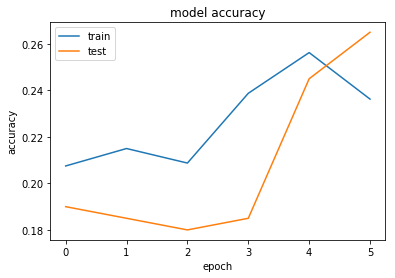

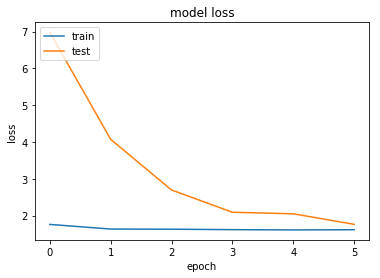

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

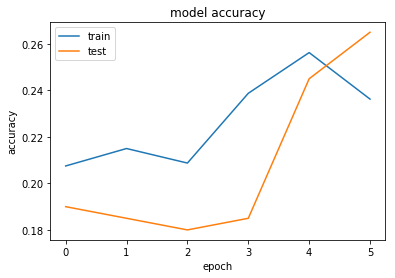

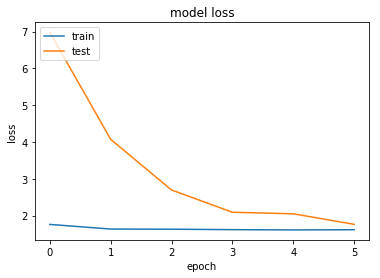

In [45]:
import matplotlib.pyplot as plt
fig1, ax = plt.subplots()
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
fig2, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [46]:
fig1.savefig('acc.png') 
fig2.savefig('loss.png') 

In [25]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)
#y_true = y_test

In [26]:
y_true

array([3, 2, 1, 2, 3, 1, 3, 4, 2, 0, 3, 0, 1, 3, 4, 1, 3, 4, 1, 1, 0, 1,
       2, 3, 2, 0, 0, 3, 0, 1, 1, 4, 2, 4, 4, 0, 2, 4, 1, 3, 3, 3, 2, 2,
       0, 3, 0, 2, 4, 2, 1, 4, 0, 4, 0, 4, 3, 4, 3, 1, 3, 1, 1, 3, 4, 4,
       1, 1, 3, 0, 4, 1, 1, 0, 4, 0, 1, 0, 2, 1, 1, 3, 1, 2, 0, 1, 4, 0,
       1, 3, 4, 1, 0, 2, 4, 1, 2, 4, 4, 4, 1, 4, 2, 0, 0, 3, 0, 2, 3, 0,
       0, 1, 1, 4, 0, 3, 1, 3, 1, 0, 4, 0, 3, 1, 3, 2, 4, 3, 0, 1, 0, 2,
       4, 3, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 4, 3, 3, 1, 2, 2, 3,
       0, 3, 0, 3, 2, 1, 1, 1, 1, 3, 4, 4, 0, 0, 0, 3, 3, 0, 0, 2, 3, 2,
       1, 2, 2, 0, 1, 4, 0, 4, 1, 4, 2, 1, 0, 3, 4, 4, 2, 0, 4, 4, 0, 2,
       4, 4])

In [27]:
pred

array([0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0,
       0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0,
       0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 4, 0, 0, 0, 4, 4, 4,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       4, 4, 4, 0, 4, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 0, 0,
       4, 0])

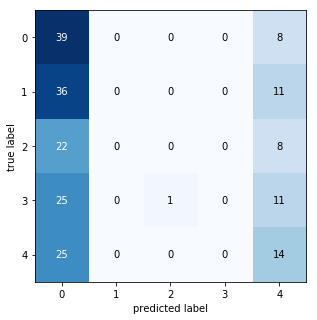

In [28]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM, figsize=(5, 5))
plt.show()

In [30]:
#plt.savefig('cm.png') 
fig.savefig('cm2.png') 

In [ ]:
precision = 390 / (390 + 137)
print(precision)

In [ ]:
recall = 390 / (390 + 0)
print(recall)

In [ ]:
f1 = (2*recall*precision) / (recall + precision)
print(f1)

In [4]:
def process_val_image(action, labels_file):
    counter = 0
    labels = pandas.read_csv(labels_file)
    X = []
    y = []

    filelist= [file for file in os.listdir('resized375x250/' + action + '/') if file.endswith('.jpeg')]
    for filename in filelist:
    #for filename in itertools.islice(filelist, 0, 1000):
        #print(filename)
        img = Image.open('resized375x250/' + action + '/' + filename)
        #imgData = list(img.getdata())
        #imgData = np.asarray(imgData)
        #imgData = img.getdata()
        #imgData = np.asarray(imgData)
        rgbimg = Image.new("RGB", img.size)
        rgbimg.paste(img)
        imgData = np.asarray(rgbimg)
        #imgData = np.asarray(img)
        #print(imgData.shape)
        #print(imgData.ndim)
        if imgData.ndim == 3:
            x = imgData.reshape(375,250,3)
            X.append(x)
            #level = labels.loc[labels['image'] == '11909_right.jpeg']
            #print(int(level['level'].values))
            print(filename)
            #print(filename[:-5])
            level = labels.loc[labels['image'] == filename[:-5]]#use for train
            #level = labels.loc[labels['image'] == filename]#use for trainModified
            #print(level)
            print(int(level['level'].values))
            y.append(int(level['level'].values))
        img.close()
        counter +=1
        if (counter % 100) == 0:
            clear_output(wait=True)
            print(counter, end =" ") 
    return X, y

In [5]:
X_validate, y_validate = process_val_image('validate', 'validateLabels.csv')

466_left.jpeg
2
936_right.jpeg
4
240_right.jpeg
1
320_left.jpeg
1
1499_left.jpeg
0
1138_right.jpeg
4
609_left.jpeg
3
1306_right.jpeg
0
679_left.jpeg
3
444_right.jpeg
2


In [9]:
X_validate = np.asarray(X_validate)
print("shape of X_validate: " + str(X_validate.shape))

shape of X_validate: (10, 375, 250, 3)


In [7]:
from keras.models import load_model
model2 = load_model('diabetic_ret_v2-3-model.h5')

/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
predictions = model2.predict(X_validate)

In [11]:
predictions

array([[7.40733325e-01, 3.89363877e-02, 2.15693757e-01, 4.63552494e-03,
        1.02044100e-06],
       [4.63815004e-01, 4.15806085e-01, 1.20005436e-01, 3.73415824e-04,
        5.01339421e-11],
       [8.17036033e-01, 1.02407951e-02, 1.72711194e-01, 7.35160825e-07,
        1.11823974e-05],
       [1.77084049e-03, 9.98126686e-01, 9.19911981e-05, 1.28676769e-09,
        1.04176124e-05],
       [5.84538043e-01, 8.00565444e-03, 4.03810412e-01, 4.92482695e-06,
        3.64094716e-03],
       [1.19509585e-01, 9.33245698e-04, 7.26478875e-01, 8.79349609e-05,
        1.52990386e-01],
       [6.71082661e-02, 9.30397928e-01, 2.48478306e-03, 9.06051173e-06,
        4.50597476e-11],
       [3.39720815e-01, 6.54086590e-01, 6.19226461e-03, 4.11724983e-07,
        3.62540753e-08],
       [1.01806246e-01, 2.40607915e-04, 4.85324115e-03, 8.93099904e-01,
        5.32149953e-13],
       [8.71330738e-01, 1.15742243e-03, 1.27073824e-01, 4.37877956e-04,
        2.23908630e-12]], dtype=float32)

In [12]:
print(np.argmax(predictions,axis = 1))

[0 0 0 1 0 2 1 1 3 0]


In [53]:
y_validate

[2, 4, 1, 1, 0, 4, 3, 0, 3, 2]